## Predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.  
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Modelling steps
1. Library imports
2. Dataset understanding
3. Variable relationships

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [115]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.externals import joblib
import pickle

In [3]:
from sklearn.externals.joblib import Memory
memory = Memory(location='/tmp', verbose=0)

In [4]:
random_state = 42

In [5]:
df = pd.read_excel('Data/Folds5x2_pp.xlsx')

## Dataset Understanding

In [6]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [7]:
df.shape

(9568, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [9]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [10]:
def plot_x_vs_y(df, x, y, kind, color = 'b', xscale_log = False, yscale_log = False):
    ax = df.plot(x =x, y = y, kind =kind, 
                 figsize = [6,6],
                 color =color, alpha = 0.3, 
                fontsize = 14, marker = 'o')
    plt.title("{} vs {}".format(x,' / '.join(y)), 
          fontsize = 18, color="darkred")
    plt.xlabel(x, fontsize = 14) 
    plt.ylabel(' / '.join(y), fontsize = 14)
    if xscale_log:
        ax.set_xscale('log')
    if yscale_log:
        ax.set_yscale('log')
    return plt

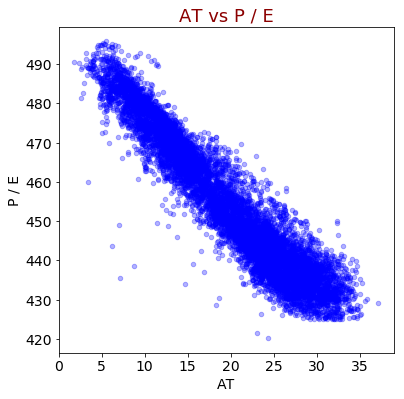

In [11]:
plot_x_vs_y(df, 'AT', 'PE', 'scatter').show()

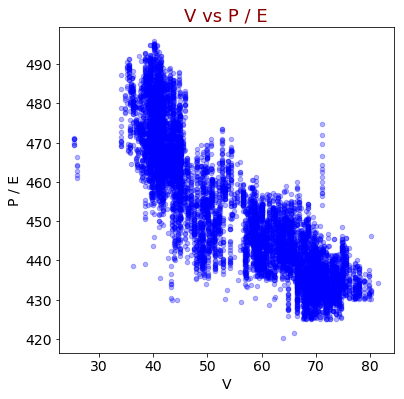

In [12]:
plot_x_vs_y(df, 'V', 'PE', 'scatter').show()

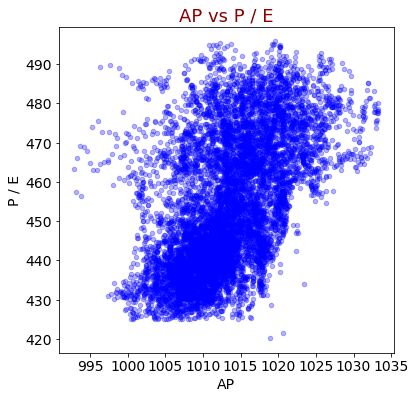

In [13]:
plot_x_vs_y(df, 'AP', 'PE', 'scatter').show()

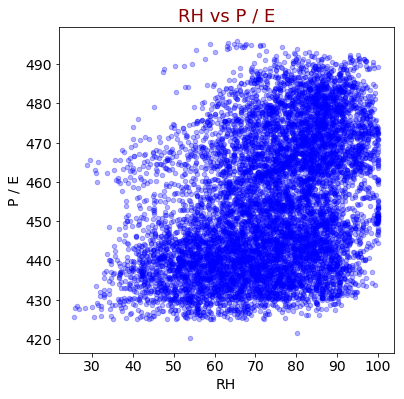

In [14]:
plot_x_vs_y(df, 'RH', 'PE', 'scatter').show()

In [15]:
corelation_mat = df.corr()
corelation_mat

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


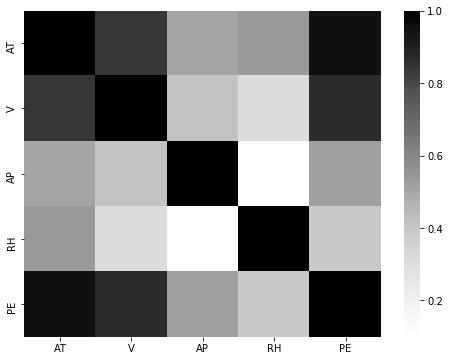

In [16]:
corelation_mat = corelation_mat.abs()
plt.figure(figsize = (8, 6))
sns.heatmap(corelation_mat, cmap="Greys",
            xticklabels=corelation_mat.columns.values,
            yticklabels=corelation_mat.columns.values)
plt.show()

High collinearity between variables and target  
But multicollinearity also present between variables

## LinearRegression

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.feature_selection import f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
X = df.drop('PE',axis=1).values
y = df.PE.values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=random_state)

In [20]:
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [21]:
var_metrics = f_regression(X_train_scaled, y_train)
pd.DataFrame(data={
    'var_name':df.drop('PE',axis=1).columns,
    'F-score' : var_metrics[0],
    'p-value' : var_metrics[1]})

,var_name,F-score,p-value
0,AT,67803.857428,0.000000e+00
1,V,23701.660696,0.000000e+00
2,AP,2816.767782,0.000000e+00
3,RH,1370.500259,4.085231e-276


In [22]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(X_train_scaled, y_train)
y_train_predict_linear_reg = linear_reg.predict(X_train_scaled)
y_test_predict_linear_reg = linear_reg.predict(X_test_scaled)

In [23]:
def print_linear_model_metrics(linear_reg, X_train_scaled, y_train, X_test_scaled, y_test):
    y_train_predict_linear_reg = linear_reg.predict(X_train_scaled)
    y_test_predict_linear_reg = linear_reg.predict(X_test_scaled)
    print('R squared is {}'.format(linear_reg.score(X_train_scaled, y_train)))
    print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_linear_reg))))
    print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_linear_reg)))
    print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_linear_reg))))
    print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_linear_reg)))
    print('Intercept is {}'.format(linear_reg.intercept_))
    print('Coefficients are')
    print(list(zip(df.drop('PE',axis=1).columns, linear_reg.coef_)))

In [24]:
print_linear_model_metrics(linear_reg, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.928331545565795
RMSE for train is 4.570930584824314
MAE for train is 3.6299902977038045
RMSE for test is 4.502633229532186
MAE for test is 3.595913178273408
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.763927385645413), ('V', -2.949632098561644), ('AP', 0.3697803165608684), ('RH', -2.3121956560685835)]


#### Model performance
Model is not overfitting since test sample accuracy is same as train

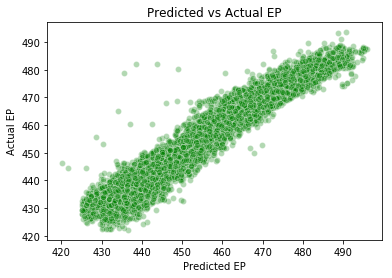

In [25]:
## Plot predictions vs actuals
ax = sns.scatterplot(x=y_train, y=y_train_predict_linear_reg, color = "g",
         alpha = 0.3, markers=True)
plt.plot(x=y_train, y=y_train, linewidth= 100, color="r")
plt.title('Predicted vs Actual EP')
plt.xlabel('Predicted EP')
plt.ylabel('Actual EP')
plt.show()

#### Performance as a fn of order of input terms

In [26]:
@memory.cache
def get_higher_order_performance(model,  X_train, X_test, y_train, y_test,
    max_order=11, other_attibutes = [], 
    alpha_perf = False, mse_path_ = '', alphas = ''):
    linear_reg_order_perf_df = pd.DataFrame()
    for order in list(range(1,max_order)):
        temp_linear_reg_poly = model
        poly_features = PolynomialFeatures(order, include_bias=False)
        temp_X_train_scaled_poly = poly_features.fit_transform(X_train)
        temp_X_test_scaled_poly = poly_features.transform(X_test)
        temp_linear_reg_poly.fit(temp_X_train_scaled_poly, y_train)
        temp_y_train_predict_linear_reg_poly = temp_linear_reg_poly.predict(temp_X_train_scaled_poly)
        temp_y_test_predict_linear_reg_poly = temp_linear_reg_poly.predict(temp_X_test_scaled_poly)
        temp_linear_reg_perf_df = pd.DataFrame({
            'order' : [order],
            'train_rmse': [np.sqrt(mean_squared_error(y_train, temp_y_train_predict_linear_reg_poly))],
            'train_mae': [mean_absolute_error(y_train, temp_y_train_predict_linear_reg_poly)],
            'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_linear_reg_poly))],
            'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_linear_reg_poly)],
            'zero_coef_count':[np.sum(np.abs(temp_linear_reg_poly.coef_)==0)],
            'total_coef':[temp_X_train_scaled_poly.shape[1]]
        })
        for attribute in other_attibutes:
            temp_linear_reg_perf_df[attribute] = getattr(temp_linear_reg_poly, attribute)
        linear_reg_order_perf_df = linear_reg_order_perf_df.append(temp_linear_reg_perf_df,ignore_index=True)
        
    linear_reg_order_perf_df['zero_coef_count_perc'] = \
        linear_reg_order_perf_df.zero_coef_count/linear_reg_order_perf_df.total_coef*100
    linear_reg_order_perf_df['non_zero_coef_count'] = \
        linear_reg_order_perf_df.total_coef - linear_reg_order_perf_df.zero_coef_count
    
    alpha_perf_df = pd.DataFrame()
    if alpha_perf:
        alpha_perf_df = pd.DataFrame({
            'alpha': getattr(temp_linear_reg_poly, alphas),
            'rmse_error':np.sqrt([np.mean(x) for x in getattr(temp_linear_reg_poly,mse_path_)])})
    
    return(linear_reg_order_perf_df, alpha_perf_df)

In [27]:
%time linear_reg_order_perf_df, _ = get_higher_order_performance( \
    LinearRegression(n_jobs=-1), X_train_scaled, X_test_scaled, y_train, y_test, other_attibutes = ['intercept_'])

CPU times: user 15.3 ms, sys: 2.94 ms, total: 18.3 ms
Wall time: 10.8 ms


In [28]:
linear_reg_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,intercept_,zero_coef_count_perc,non_zero_coef_count
0,1,4.570931,3.629990,4.502633,3.595913,0,4,454.431040,0.0,4
1,2,4.261402,3.348581,4.231200,3.351350,0,14,453.236508,0.0,14
2,3,4.161328,3.228277,4.107230,3.221318,0,34,453.489549,0.0,34
3,4,4.087943,3.149965,4.062031,3.167286,0,69,453.371284,0.0,69
4,5,3.981601,3.037283,3.936879,3.057127,0,125,453.078571,0.0,125
5,6,3.908271,2.965268,4.233796,3.086302,0,209,453.123946,0.0,209
6,7,3.808869,2.862402,4.067575,3.020612,0,329,453.041658,0.0,329
7,8,3.708867,2.763251,4.404361,3.092148,0,494,453.154272,0.0,494
8,9,3.584362,2.657439,13.234649,3.587365,0,714,453.598048,0.0,714
9,10,3.451951,2.544936,25.836677,4.418608,0,1000,453.572732,0.0,1000


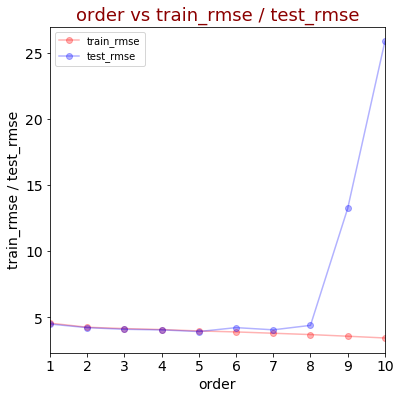

In [29]:
plot_x_vs_y(linear_reg_order_perf_df, 'order', ['train_rmse','test_rmse'], 'line', color = ['r', 'b']).show()

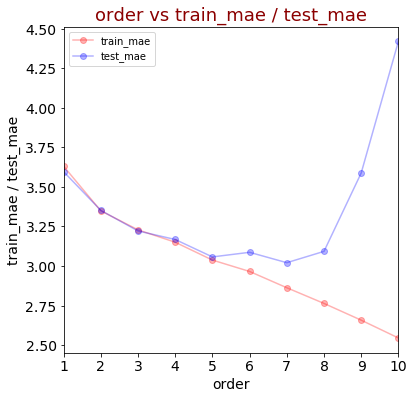

In [30]:
plot_x_vs_y(linear_reg_order_perf_df, 'order', ['train_mae','test_mae'], 'line', color = ['r', 'b']).show()

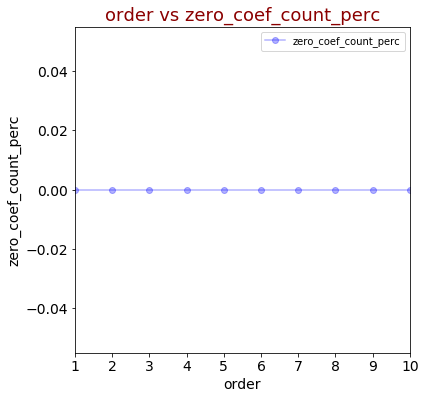

In [31]:
plot_x_vs_y(linear_reg_order_perf_df, 'order', ['zero_coef_count_perc'], 'line', color = ['b']).show()

#### Was able to significantly reduce error by introducing higher order terms upto 5th degree

#### Check test and performance as a function of number of rows in training data

In [32]:
linear_reg_perf_df = pd.DataFrame()

In [33]:
for row_count in [10, 30, 50, 100, 500, 1000, 2500, 5000, len(X_train_scaled)]:
    temp_linear_reg = LinearRegression(n_jobs=-1)
    random.seed(random_state)
    select_rows = random.sample(list(range(0,len(X_train_scaled))), row_count)
    selected_X_train = X_train_scaled[select_rows,:]
    selected_y_train = y_train[select_rows]
    temp_linear_reg.fit(selected_X_train, selected_y_train)
    temp_y_train_predict_linear_reg = temp_linear_reg.predict(selected_X_train)
    temp_y_test_predict_linear_reg = temp_linear_reg.predict(X_test_scaled)
    temp_linear_reg_perf_df = pd.DataFrame({
        'row_count' : [row_count],
        'train_rmse': [np.sqrt(mean_squared_error(selected_y_train, temp_y_train_predict_linear_reg))],
        'train_mae': [mean_absolute_error(selected_y_train, temp_y_train_predict_linear_reg)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_linear_reg))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_linear_reg)],
    })
    linear_reg_perf_df = linear_reg_perf_df.append(temp_linear_reg_perf_df,ignore_index=True)

In [34]:
linear_reg_perf_df

,row_count,train_rmse,train_mae,test_rmse,test_mae
0,10,1.835914,1.562390,6.358759,4.907398
1,30,3.931334,2.997221,5.546896,4.300476
2,50,4.075155,3.340928,5.071087,3.923324
3,100,4.437137,3.645562,4.594953,3.676422
4,500,4.539067,3.722846,4.523302,3.612895
5,1000,4.530335,3.691833,4.528917,3.615060
6,2500,4.579715,3.648711,4.503992,3.598108
7,5000,4.510692,3.612358,4.507555,3.594542
8,7654,4.570931,3.629990,4.502633,3.595913


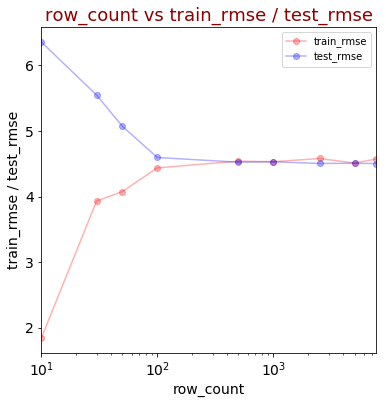

In [35]:
plot_x_vs_y(linear_reg_perf_df, 'row_count', ['train_rmse','test_rmse'],
            'line', color = ['r', 'b'], xscale_log=True).show()

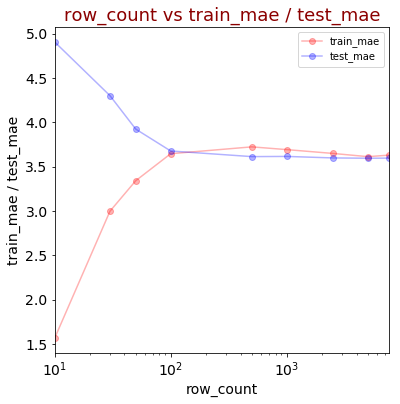

In [36]:
plot_x_vs_y(linear_reg_perf_df, 'row_count', ['train_mae','test_mae'],
            'line', color = ['r', 'b'], xscale_log=True).show()

## Lasso Linear Regression

In [37]:
lasso = Lasso(random_state=random_state)
lasso.fit(X_train_scaled, y_train)
y_train_predict_lasso = lasso.predict(X_train_scaled)
y_test_predict_lasso = lasso.predict(X_test_scaled)

In [38]:
print_linear_model_metrics(lasso, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.9129297742387136
RMSE for train is 5.038200444815834
MAE for train is 4.0241362943955705
RMSE for test is 4.943133196423315
MAE for test is 3.9461006085541355
Intercept is 454.4310399790958
Coefficients are
[('AT', -12.051787726760587), ('V', -3.578659330148499), ('AP', 0.25017866227595714), ('RH', -0.022608239736492466)]


#### Model performance
Model is worse off as compared to linear regression with default parameter of alpha

### Lasso CV

In [39]:
lasso_cv = LassoCV(cv=5, verbose=True,n_jobs=-1,random_state=random_state, eps=1e-6, n_alphas=1000)
lasso_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=5, eps=1e-06, fit_intercept=True,
    max_iter=1000, n_alphas=1000, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.0001, verbose=True)

In [40]:
lasso_cv.alpha_

0.00044726279131466286

In [41]:
alpha_perf_df = pd.DataFrame({
    'alpha':lasso_cv.alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in lasso_cv.mse_path_])})

In [42]:
alpha_perf_df

,alpha,rmse_error
0,16.185321,17.066840
1,15.963030,16.866451
2,15.743791,16.659033
3,15.527563,16.454765
4,15.314305,16.253606
5,15.103976,16.055517
6,14.896536,15.860458
7,14.691945,15.668391
8,14.490163,15.479277
9,14.291153,15.293079


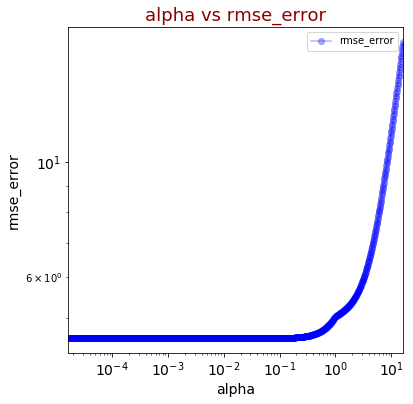

In [43]:
plot_x_vs_y(alpha_perf_df, 'alpha', ['rmse_error'],
            'line', color = ['b'], xscale_log=True, yscale_log=True).show()

In [44]:
y_train_predict_lasso_cv = lasso_cv.predict(X_train_scaled)
y_test_predict_lasso_cv = lasso_cv.predict(X_test_scaled)

In [45]:
print_linear_model_metrics(lasso_cv, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.9283315404360332
RMSE for train is 4.5709307484094275
MAE for train is 3.62994570688001
RMSE for test is 4.50266005314189
MAE for test is 3.5959011517951196
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.766383008418632), ('V', -2.9477032578241236), ('AP', 0.36894346223773716), ('RH', -2.3123982209336256)]


### Lasso LARS CV

In [46]:
lasso_lars_cv = LassoLarsCV(cv=5, verbose=True,n_jobs=-1, max_iter=1000,eps=1e-15, max_n_alphas=1000)
lasso_lars_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


LassoLarsCV(copy_X=True, cv=5, eps=1e-15, fit_intercept=True, max_iter=1000,
      max_n_alphas=1000, n_jobs=-1, normalize=True, positive=False,
      precompute='auto', verbose=True)

In [47]:
lasso_lars_cv.alpha_

0.0

In [48]:
alpha_perf_df = pd.DataFrame({
    'alpha':lasso_lars_cv.cv_alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in lasso_lars_cv.mse_path_])})

In [49]:
alpha_perf_df

,alpha,rmse_error
0,0.000000,4.573755
1,0.012530,5.024223
2,0.012850,5.042995
3,0.012860,5.043484
4,0.013109,5.053444
5,0.013124,5.053895
6,0.016469,5.138375
7,0.017082,5.154640
8,0.018083,5.180716
9,0.018300,5.186271


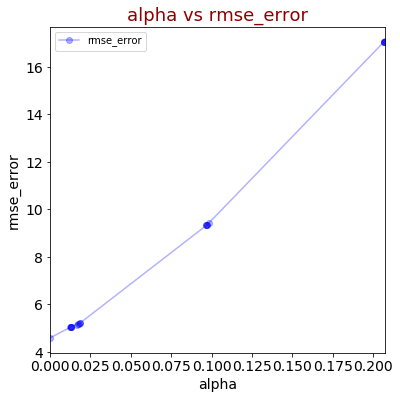

In [50]:
plot_x_vs_y(alpha_perf_df, 'alpha', ['rmse_error'],
            'line', color = ['b']).show()

In [51]:
y_train_predict_lasso_lars_cv = lasso_lars_cv.predict(X_train_scaled)
y_test_predict_lasso_lars_cv = lasso_lars_cv.predict(X_test_scaled)

In [52]:
print_linear_model_metrics(lasso_lars_cv, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.928331545565795
RMSE for train is 4.570930584824314
MAE for train is 3.6299902977038054
RMSE for test is 4.502633229532185
MAE for test is 3.5959131782734066
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.763927385645385), ('V', -2.949632098561657), ('AP', 0.36978031656087335), ('RH', -2.312195656068577)]


### Lasso higher dimensions

#### Lasso CV

In [140]:
%time lasso_order_perf_df, alpha_perf_df = get_higher_order_performance( \
    LassoCV(cv=5, verbose=False,n_jobs=-1, \
            random_state=random_state,eps=1e-6, n_alphas=1000,  max_iter=10000), \
    X_train_scaled, X_test_scaled, y_train, y_test, \
    other_attibutes = ['intercept_', 'alpha_'], \
    alpha_perf = True, mse_path_ = 'mse_path_', alphas = 'alphas_')

CPU times: user 8.16 ms, sys: 3.12 ms, total: 11.3 ms
Wall time: 12.7 ms


In [54]:
lasso_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,intercept_,alpha_,zero_coef_count_perc,non_zero_coef_count
0,1,4.570931,3.629946,4.502660,3.595901,0,4,454.431040,0.000447,0.000000,4
1,2,4.261795,3.351944,4.232357,3.354211,1,14,453.189427,0.009906,7.142857,13
2,3,4.161331,3.228343,4.107342,3.221506,0,34,453.488362,0.000128,0.000000,34
3,4,4.088431,3.149498,4.062863,3.167374,2,69,453.432369,0.000539,2.898551,67
4,5,3.985337,3.041145,3.938533,3.060948,1,125,453.123984,0.000247,0.800000,124
5,6,3.926175,2.986500,4.132059,3.077791,3,209,453.184110,0.000404,1.435407,206
6,7,3.871907,2.933342,3.913101,3.030737,53,329,453.204510,0.001506,16.109422,276
7,8,3.890287,2.951069,4.232024,3.099914,206,494,453.582122,0.006946,41.700405,288
8,9,3.962548,3.030058,4.024188,3.118658,503,714,453.524999,0.032768,70.448179,211
9,10,4.006795,3.081597,4.102297,3.168909,782,1000,453.482351,0.072650,78.200000,218


In [55]:
alpha_perf_df

,alpha,rmse_error
0,16542.209757,17.075104
1,16315.016503,17.073479
2,16090.943556,17.071528
3,15869.948061,17.069175
4,15651.987753,17.066728
5,15437.020945,17.064347
6,15225.006524,17.062030
7,15015.903941,17.059778
8,14809.673206,17.057586
9,14606.274876,17.055454


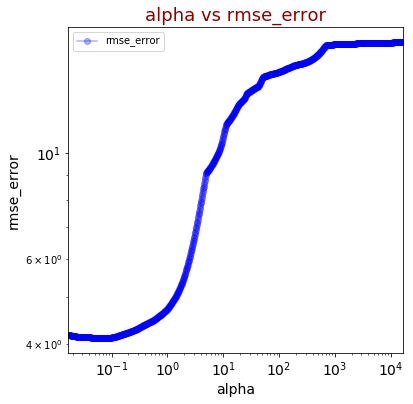

In [56]:
plot_x_vs_y(alpha_perf_df, 'alpha', ['rmse_error'],
            'line', color = ['b'], xscale_log=True, yscale_log=True).show()

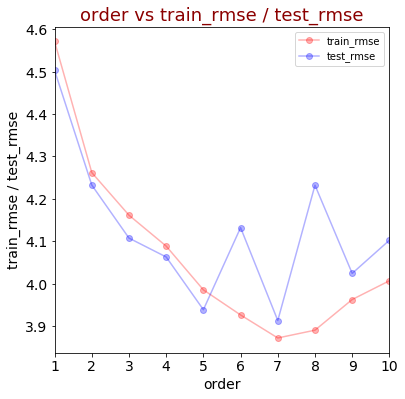

In [57]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['train_rmse','test_rmse'],
            'line', color = ['r','b']).show()

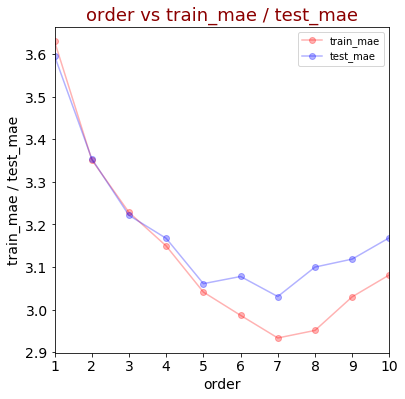

In [58]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['train_mae','test_mae'],
            'line', color = ['r','b']).show()

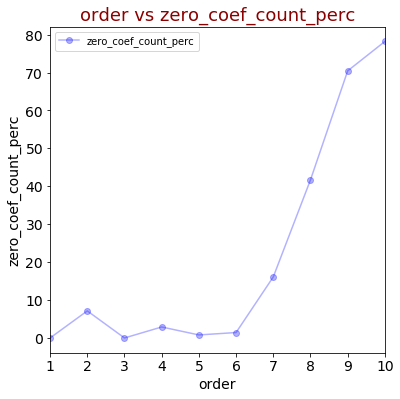

In [59]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['zero_coef_count_perc'],
            'line', color = ['b']).show()

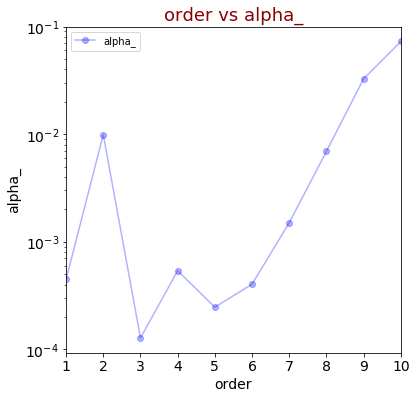

In [60]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['alpha_'],
            'line', color = ['b'], yscale_log=True).show()

#### Lasso lars CV

In [61]:
%time lasso_order_perf_df, alpha_perf_df = get_higher_order_performance( \
    LassoLarsCV(cv=5, verbose=False,n_jobs=-1, max_iter=10000,eps=1e-15, max_n_alphas=1000), \
    X_train_scaled, X_test_scaled, y_train, y_test, \
    other_attibutes = ['intercept_', 'alpha_'], \
    alpha_perf = True, mse_path_ = 'mse_path_', alphas = 'cv_alphas_')

CPU times: user 14.2 s, sys: 11.4 s, total: 25.6 s
Wall time: 2min 3s


In [62]:
lasso_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,intercept_,alpha_,zero_coef_count_perc,non_zero_coef_count
0,1,4.570931,3.629990,4.502633,3.595913,0,4,454.431040,0.000000,0.000000,4
1,2,4.262191,3.353210,4.232325,3.354527,1,14,453.169520,0.000185,7.142857,13
2,3,4.161332,3.228338,4.107366,3.221523,0,34,453.488711,0.000001,0.000000,34
3,4,4.088689,3.149757,4.063345,3.167665,2,69,453.441424,0.000005,2.898551,67
4,5,3.983114,3.038870,3.936517,3.057296,5,125,453.088546,0.000001,4.000000,120
5,6,3.920051,2.979568,4.100258,3.071278,24,209,453.202305,0.000002,11.483254,185
6,7,3.868158,2.928005,3.888315,3.011652,93,329,453.087864,0.000004,28.267477,236
7,8,3.865034,2.925650,3.934554,3.036470,257,494,453.540941,0.000010,52.024291,237
8,9,3.789989,2.850400,4.071701,3.036593,378,714,453.394143,0.000004,52.941176,336
9,10,3.804726,2.861894,4.197770,3.043771,686,1000,453.542709,0.000006,68.600000,314


In [64]:
alpha_perf_df

,alpha,rmse_error
0,1.186441e-07,6.479384
1,1.198111e-07,6.460569
2,1.204622e-07,6.446629
3,1.213573e-07,6.426004
4,1.220922e-07,6.409710
5,1.230831e-07,6.388613
6,1.238491e-07,6.371870
7,1.243283e-07,6.361376
8,1.251456e-07,6.343756
9,1.259592e-07,6.326180


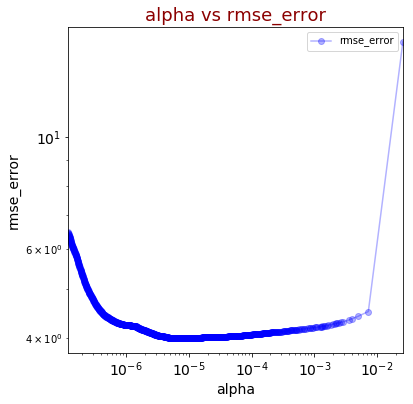

In [65]:
plot_x_vs_y(alpha_perf_df, 'alpha', ['rmse_error'],
            'line', color = ['b'], xscale_log=True, yscale_log=True).show()

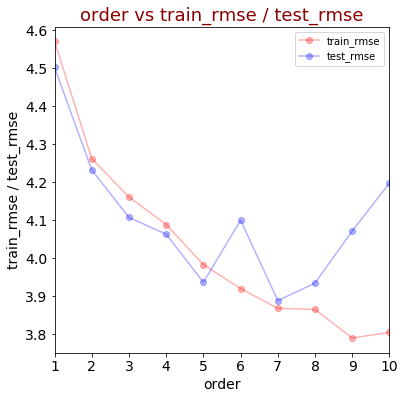

In [66]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['train_rmse','test_rmse'],
            'line', color = ['r','b']).show()

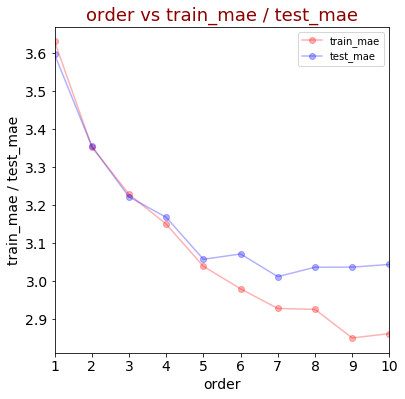

In [67]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['train_mae','test_mae'],
            'line', color = ['r','b']).show()

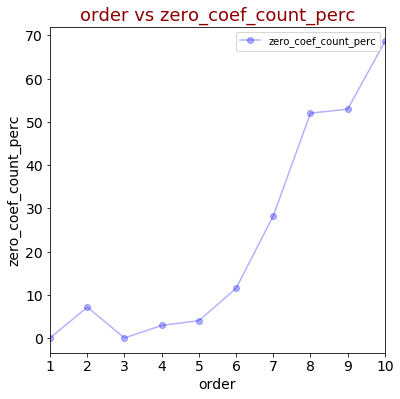

In [68]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['zero_coef_count_perc'],
            'line', color = ['b']).show()

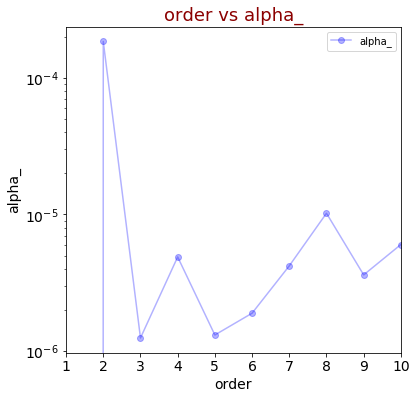

In [69]:
plot_x_vs_y(lasso_order_perf_df, 'order', ['alpha_'],
            'line', color = ['b'], yscale_log=True).show()

## Ridge regression

In [70]:
ridge = Ridge(random_state=random_state)
ridge.fit(X_train_scaled, y_train)
y_train_predict_ridge = ridge.predict(X_train_scaled)
y_test_predict_ridge = ridge.predict(X_test_scaled)

In [71]:
print_linear_model_metrics(ridge, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.9283314811577155
RMSE for train is 4.570932638760015
MAE for train is 3.6301674922303837
RMSE for test is 4.502509880840363
MAE for test is 3.595852435980496
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.753451898527599), ('V', -2.955977798968213), ('AP', 0.37201470916166174), ('RH', -2.308402121790891)]


#### Model performance
Model is similiar to linear regression with default parameter of alpha

In [72]:
ridge_cv = RidgeCV(store_cv_values=True,alphas=np.geomspace(1e-6,10,100))
ridge_cv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000e-06, 1.17681e-06, ..., 8.49753e+00, 1.00000e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [73]:
ridge_cv.alpha_

0.2009233002565046

In [74]:
y_train_predict_ridge_cv = ridge_cv.predict(X_train_scaled)
y_test_predict_ridge_cv = ridge_cv.predict(X_test_scaled)

In [75]:
print_linear_model_metrics(ridge_cv, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.9283315429607297
RMSE for train is 4.570930667898326
MAE for train is 3.6300253097318915
RMSE for test is 4.502608088406074
MAE for test is 3.595900877508091
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.761820575135971), ('V', -2.9509085732991025), ('AP', 0.37022965457913415), ('RH', -2.311432757342345)]


### Higher order terms

In [85]:
%time ridge_order_perf_df, _ = get_higher_order_performance( \
    RidgeCV(store_cv_values=False,alphas=np.geomspace(1e-6,10,100), cv=5), \
    X_train_scaled, X_test_scaled, y_train, y_test, \
    other_attibutes = ['intercept_', 'alpha_'])

CPU times: user 13.3 ms, sys: 4.76 ms, total: 18.1 ms
Wall time: 18.7 ms


In [86]:
ridge_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,intercept_,alpha_,zero_coef_count_perc,non_zero_coef_count
0,1,4.570932,3.630121,4.502542,3.595868,0,4,454.431040,0.739072,0.0,4
1,2,4.261405,3.348683,4.231115,3.351369,0,14,453.232649,1.204504,0.0,14
2,3,4.161444,3.228955,4.107209,3.222420,0,34,453.476082,3.764936,0.0,34
3,4,4.088249,3.149532,4.062218,3.167714,0,69,453.416409,2.310130,0.0,69
4,5,3.987418,3.043138,3.939603,3.062430,0,125,453.171666,3.764936,0.0,125
5,6,3.918880,2.977482,4.170908,3.082171,0,209,453.183495,2.310130,0.0,209
6,7,3.855532,2.920343,3.984122,3.042296,0,329,453.074853,10.000000,0.0,329
7,8,3.791574,2.853268,3.954105,3.021781,0,494,453.206833,10.000000,0.0,494
8,9,3.719100,2.783480,8.418811,3.236867,0,714,453.203329,10.000000,0.0,714
9,10,3.658832,2.718808,4.011201,2.992746,0,1000,453.234064,10.000000,0.0,1000


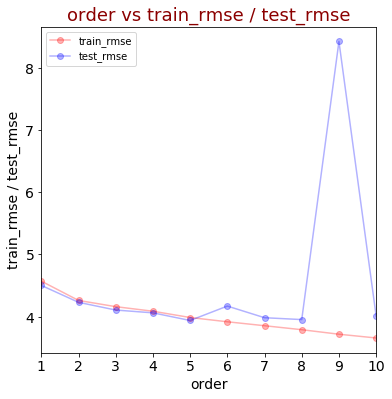

In [87]:
plot_x_vs_y(ridge_order_perf_df, 'order', ['train_rmse','test_rmse'],
            'line', color = ['r','b']).show()

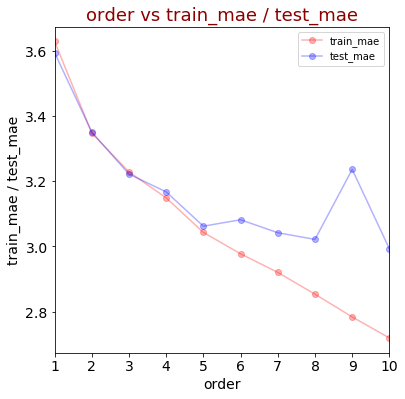

In [88]:
plot_x_vs_y(ridge_order_perf_df, 'order', ['train_mae','test_mae'],
            'line', color = ['r','b']).show()

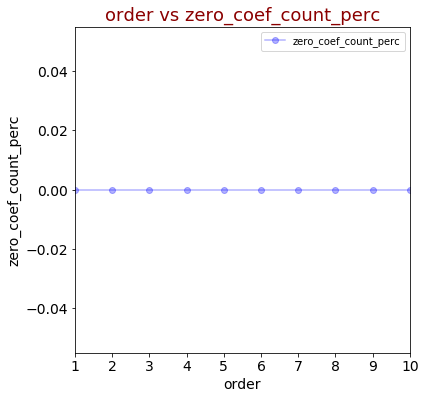

In [89]:
plot_x_vs_y(ridge_order_perf_df, 'order', ['zero_coef_count_perc'],
            'line', color = ['b']).show()

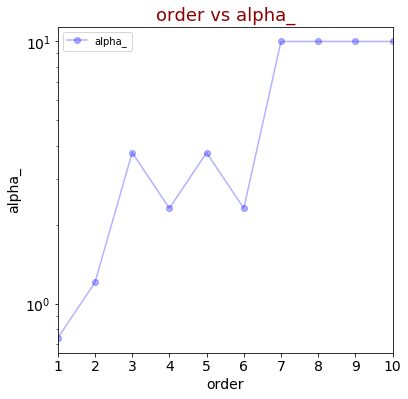

In [90]:
plot_x_vs_y(ridge_order_perf_df, 'order', ['alpha_'],
            'line', color = ['b'], yscale_log=True).show()

## Elastic net

In [91]:
ElasticNet?

In [92]:
elastic_net = ElasticNet(random_state=random_state)
elastic_net.fit(X_train_scaled, y_train)
y_train_predict_elastic_net = elastic_net.predict(X_train_scaled)
y_test_predict_elastic_net = elastic_net.predict(X_test_scaled)

In [93]:
print_linear_model_metrics(elastic_net, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.8589470396902024
RMSE for train is 6.412563951015565
MAE for train is 5.143514975813992
RMSE for test is 6.28666096319464
MAE for test is 5.052080581212624
Intercept is 454.4310399790954
Coefficients are
[('AT', -6.778442153498668), ('V', -5.150496563143049), ('AP', 1.814349339825714), ('RH', 0.46215564774837975)]


#### Model performance
Model is worse off as compared to linear regression with default parameters of alpha and l1

In [120]:
ElasticNetCV?

l1 = 1 -> Lasso  
l1 = 0 -> Ridge

In [110]:
elastic_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], random_state=random_state,
    alphas=np.geomspace(1e-6,10,1000), max_iter=1000, cv = 5, n_jobs=-1)
elastic_net_cv.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=array([1.00000e-06, 1.01627e-06, ..., 9.83995e+00, 1.00000e+01]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
       verbose=0)

In [111]:
elastic_net_cv.l1_ratio_, elastic_net_cv.alpha_

(0.1, 0.00010940547072057424)

In [127]:
len(elastic_net_cv.mse_path_)

7

In [112]:
y_train_predict_elastic_net_cv = elastic_net_cv.predict(X_train_scaled)
y_test_predict_elastic_net_cv = elastic_net_cv.predict(X_test_scaled)

In [113]:
print_linear_model_metrics(elastic_net_cv, X_train_scaled, y_train, X_test_scaled, y_test)

R squared is 0.9283315095501993
RMSE for train is 4.570931733340552
MAE for train is 3.6301221240421535
RMSE for test is 4.502540607326527
MAE for test is 3.595866824265882
Intercept is 454.4310399790958
Coefficients are
[('AT', -14.756099471460457), ('V', -2.9543635110649586), ('AP', 0.3714422829565393), ('RH', -2.3093439046398596)]


### Higher order terms

In [141]:
%time elastic_net_order_perf_df, alpha_perf_df = get_higher_order_performance( \
    ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], random_state=random_state, \
        alphas=np.geomspace(1e-6,10,100), max_iter=1000, cv = 5, n_jobs=-1), \
    X_train_scaled, X_test_scaled, y_train, y_test, \
    other_attibutes = ['intercept_', 'alpha_', 'l1_ratio_'], \
    alpha_perf = False, mse_path_ = 'mse_path_', alphas = 'alphas_')

CPU times: user 7.52 ms, sys: 2.36 ms, total: 9.88 ms
Wall time: 10.5 ms


In [135]:
elastic_net_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,intercept_,alpha_,l1_ratio_,zero_coef_count_perc,non_zero_coef_count
0,1,4.570932,3.630126,4.502538,3.595866,0,4,454.431040,0.000112,0.10,0.000000,4
1,2,4.261838,3.352151,4.232346,3.354310,1,14,453.188992,0.010723,1.00,7.142857,13
2,3,4.161521,3.228797,4.107412,3.222283,0,34,453.466955,0.000673,0.10,0.000000,34
3,4,4.090828,3.148096,4.066494,3.168489,0,69,453.532582,0.000572,0.70,0.000000,69
4,5,4.000982,3.051807,3.955757,3.076311,0,125,453.270045,0.000016,0.10,0.000000,125
5,6,3.947840,3.005277,4.076832,3.084684,0,209,453.252072,0.000351,0.95,0.000000,209
6,7,3.905844,2.970883,3.925536,3.057694,0,329,453.431698,0.001097,0.10,0.000000,329
7,8,3.893518,2.957921,4.110122,3.093911,29,494,453.321017,0.002915,0.70,5.870445,465
8,9,3.931048,2.997730,3.990141,3.092944,316,714,453.424973,0.014850,0.99,44.257703,398
9,10,3.958548,3.027501,4.061610,3.126417,554,1000,453.539357,0.033516,1.00,55.400000,446


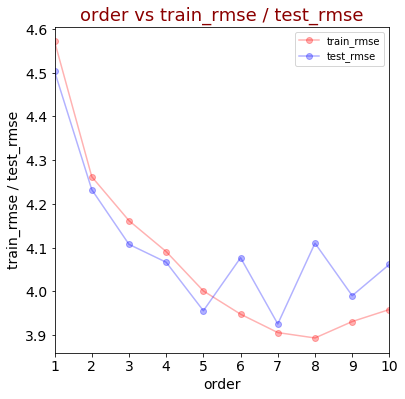

In [136]:
plot_x_vs_y(elastic_net_order_perf_df, 'order', ['train_rmse','test_rmse'],
            'line', color = ['r','b']).show()

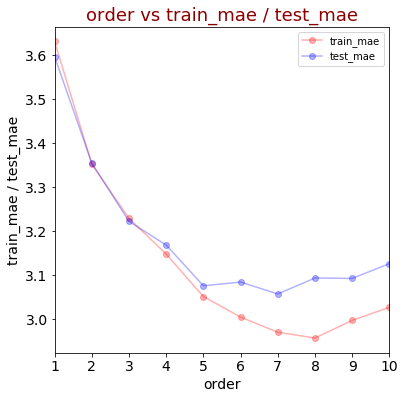

In [137]:
plot_x_vs_y(elastic_net_order_perf_df, 'order', ['train_mae','test_mae'],
            'line', color = ['r','b']).show()

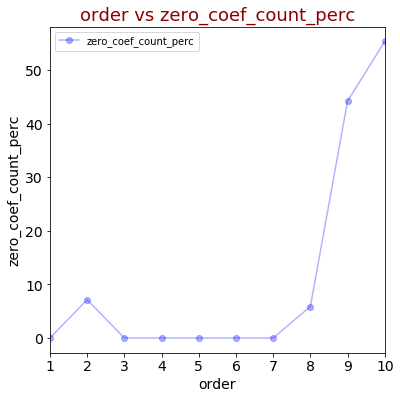

In [138]:
plot_x_vs_y(elastic_net_order_perf_df, 'order', ['zero_coef_count_perc'],
            'line', color = ['b']).show()

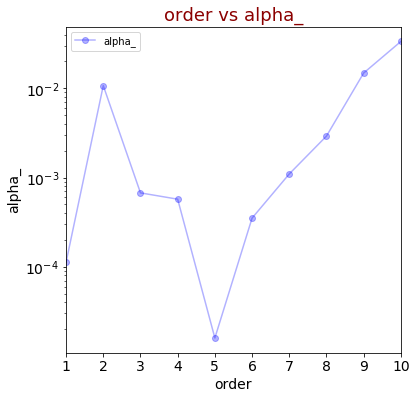

In [139]:
plot_x_vs_y(elastic_net_order_perf_df, 'order', ['alpha_'],
            'line', color = ['b'], yscale_log=True).show()

## Final Metrics for linear models

**Linear Regression**  
RMSE for test is 4.503  
MAE for test is 3.596  
**_Fifth degree_**  
RMSE for test is 3.936  
MAE for test is 3.057  

**Lasso Regression**  
RMSE for test is 4.503  
MAE for test is 3.596  
**_Fifth degree_**  
RMSE for test is 3.938   
MAE for test is 3.061	

**Lasso LARS Regression**  
RMSE for test is 4.503  
MAE for test is 3.596  
**_Fifth degree_**  
RMSE for test is 3.936   
MAE for test is 3.057  

**Ridge Regression**  
RMSE for test is 4.503  
MAE for test is 3.596  
**_Fifth degree_**  
RMSE for test is 3.939  
MAE for test is 3.062  

**Elastic Net**  
RMSE for test is 4.503  
MAE for test is 3.596  
**_Fifth degree_**  
RMSE for test is 3.955   
MAE for test is 3.076  